In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

# General task Exercise 2A:
Train a character-level language model to generate names (persons, companies, animals, etc) in your language
of choice1
. Assess your model’s quality

In [ ]:
!wget https://raw.githubusercontent.com/estersct/NLP/main/spanish_names.txt

In [3]:
# Load the Spanish names from the uploaded file
file_path = 'spanish_names.txt'
spanish_words = open(file_path, 'r').read().splitlines()

# Process the data to create a vocabulary of characters
chars = sorted(list(set(''.join(spanish_words) + "ñáéíóúüÑÁÉÍÓÚÜ")))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0  # Adding a special token for end of name
itos = {i: s for s, i in stoi.items()}

# Build the dataset with the new Spanish names
block_size = 3  # context length

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# Splitting the dataset into training, validation, and test sets
random.seed(42)
random.shuffle(spanish_words)
n1 = int(0.8 * len(spanish_words))
n2 = int(0.9 * len(spanish_words))

Xtr, Ytr = build_dataset(spanish_words[:n1])
Xdev, Ydev = build_dataset(spanish_words[n1:n2])
Xte, Yte = build_dataset(spanish_words[n2:])

# Initialize parameters for the neural network
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
num_chars = len(stoi)  # Number of unique characters
C = torch.randn((num_chars, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, num_chars), generator=g)
b2 = torch.randn(num_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [4]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [5]:
# Assuming 'input_tensor' is your input tensor
input_shape = Xtr.size()
print("Shape of input tensor:", input_shape)
# Assuming Ytr is your target variable
num_classes = torch.unique(Ytr).size(0)
print("Number of classes in the dataset:", num_classes)

Shape of input tensor: torch.Size([233991, 3])
Number of classes in the dataset: 29


In [6]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

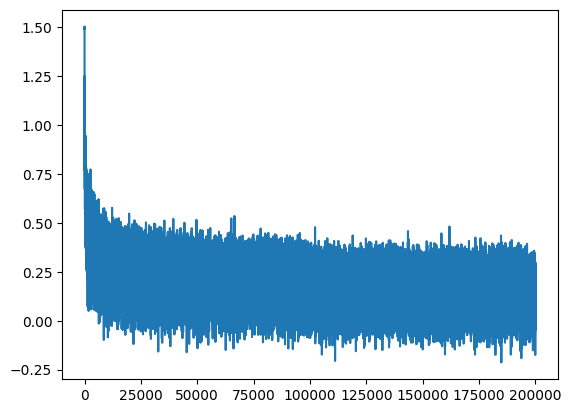

In [7]:
plt.plot(stepi, lossi)

In [8]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.4679, grad_fn=<NllLossBackward0>)

In [9]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.5318, grad_fn=<NllLossBackward0>)

In [10]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.5169, grad_fn=<NllLossBackward0>)

In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

CRISTIKA MARICIA.
BALINA.
STEFA.
ANABELYS.
MONA BERNACIONELLA JOSEFANIA VALLENA.
AMARIA ALMA BELA.
VIENA YAIZABETH.
MONA.
ROSA ASMINESBA.
VEROSA.
CINTIA HELODISSA.
FATIA EWA.
SOFIA IZABETH.
LIA.
ROSA.
CIMONINDY VALEXIN.
MARIANA VANDREA VANA.
PAULA BEL.
GZDITH.
VUTINA.


# Specific task 2A-I: Multiple models; multiple languages
Pick a second language. Build a second character-level model for this language and assess its quality.

In [ ]:
!wget https://raw.githubusercontent.com/estersct/NLP/main/french_names.txt

In [13]:
# Load the French names from the uploaded file
french_file_path = 'french_names.txt'
french_words = open(french_file_path, 'r', encoding='ISO-8859-1').read().splitlines()

# Process the data to create a vocabulary of characters
# Including French-specific characters
french_chars = sorted(list(set(''.join(french_words) + "àâäæçéèêëîïôœùûüÿÀÂÄÆÇÉÈÊËÎÏÔŒÙÛÜŸ")))
stoi_french = {s: i + 1 for i, s in enumerate(french_chars)}
stoi_french['.'] = 0  # Adding a special token for end of name
itos_french = {i: s for s, i in stoi_french.items()}

In [14]:
# Build the dataset with the new French names
block_size = 3  # context length

def build_dataset(french_words):
    X, Y = [], []
    for w in french_words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi_french[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# Splitting the dataset into training, validation, and test sets
random.seed(42)
random.shuffle(french_words)
n1 = int(0.8 * len(french_words))
n2 = int(0.9 * len(french_words))

Xtr_french, Ytr_french = build_dataset(french_words[:n1])
Xdev_french, Ydev_french = build_dataset(french_words[n1:n2])
Xte_french, Yte_french = build_dataset(french_words[n2:])

# Step 4: Initialize parameters for the neural network modifying weights and biases
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
num_french_chars = len(stoi_french)  # Number of unique characters
C = torch.randn((num_french_chars, 10), generator=g)
W1 = torch.randn((30, 50), generator=g)
b1 = torch.randn(50, generator=g)
W2 = torch.randn((50, num_french_chars), generator=g)
b2 = torch.randn(num_french_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters :
    p.requires_grad = True

In [15]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [16]:
# Assuming 'input_tensor' is your input tensor
input_shape = Xtr_french.size()
print("Shape of input tensor:", input_shape)
# Assuming Ytr is your target variable
num_classes = torch.unique(Ytr_french).size(0)
print("Number of classes in the dataset:", num_classes)

Shape of input tensor: torch.Size([64984, 3])
Number of classes in the dataset: 37


In [17]:
for i in range(200000):

  # minibatch construct (double than the Spanish model)
  ix = torch.randint(0, min(Xtr.shape[0], Xtr_french.shape[0], Ytr_french.shape[0]), (64,))

  # forward pass
  emb = C[Xtr_french[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr_french[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update learning rate (decreased)
  #lr = lrs[i]
  lr_french = 0.05 if i < 100000 else 0.005
  for p in parameters :
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

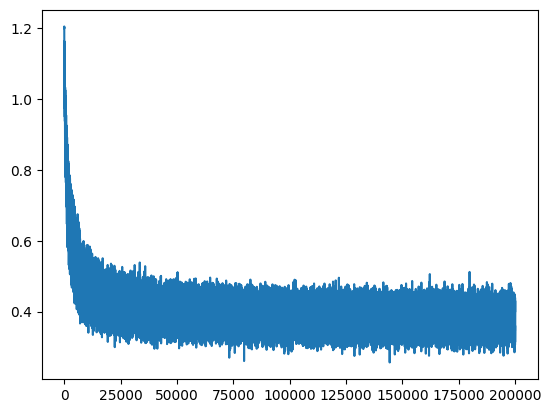

In [18]:
plt.plot(stepi, lossi)

In [19]:
# training loss
emb = C[Xtr_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr_french)
loss

tensor(2.4092, grad_fn=<NllLossBackward0>)

In [20]:
# validation loss
emb = C[Xdev_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev_french)
loss

tensor(2.4310, grad_fn=<NllLossBackward0>)

In [21]:
# test loss
emb = C[Xte_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte_french)
loss

tensor(2.4253, grad_fn=<NllLossBackward0>)

In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos_french[i] for i in out))

chellaco (1).
jald.
.
hoyle.
lalmi.
eaf.
ber.
stina.
erb.
kerzo.
efrie.
isilie.
noh.
afolacilann.
deiphile.
naphoris.
auth.
jasagnelleera.
zus.
lus.


Then
assess your first model on the task of generating names for the second language, and vice-versa.

In [23]:
# French on Spanish model
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr_french.shape[0], (32,))

  # forward pass
  emb = C[Xtr_french[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr_french[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

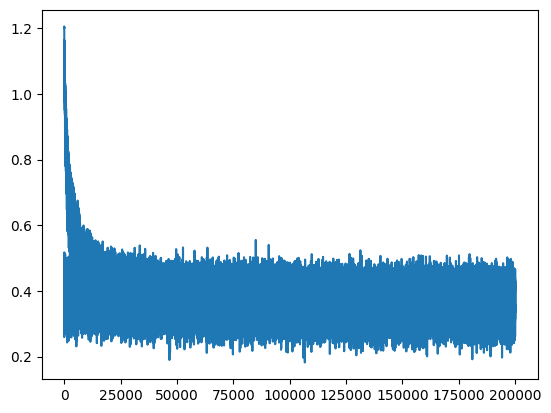

In [24]:
plt.plot(stepi, lossi)

In [25]:
# training loss
emb = C[Xtr_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr_french)
loss

tensor(2.3251, grad_fn=<NllLossBackward0>)

In [26]:
# validation loss
emb = C[Xdev_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev_french)
loss

tensor(2.3730, grad_fn=<NllLossBackward0>)

In [27]:
# test loss
emb = C[Xte_french] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte_french)
loss

tensor(2.3835, grad_fn=<NllLossBackward0>)

In [28]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos_french[i] for i in out))

chellacodephosh.
dardo.
bert.
lainea.
hata.
stenan.
junne.
zorefa.
.
ainilie.
nicharopalieghind.
iperleina.
cori.
.
auth.
jasagndeleerakuus.
lus.
solond.
gai.
ale.


In [29]:
# Spanish on French model
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
num_chars = len(stoi)  # Number of unique characters
C = torch.randn((num_chars, 10), generator=g)
W1 = torch.randn((30, 50), generator=g)
b1 = torch.randn(50, generator=g)
W2 = torch.randn((50, num_chars), generator=g)
b2 = torch.randn(num_chars, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters :
    p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
lri = []
lossi = []
stepi = []

In [30]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, min(Xtr.shape[0], Ytr.shape[0]), (64,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.05 if i < 100000 else 0.005
  for p in parameters :
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

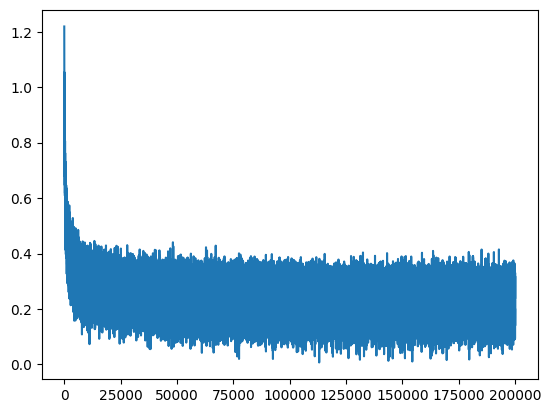

In [31]:
plt.plot(stepi, lossi)

In [32]:
# training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.6809, grad_fn=<NllLossBackward0>)

In [33]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.7038, grad_fn=<NllLossBackward0>)

In [34]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(1.6867, grad_fn=<NllLossBackward0>)

In [35]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      emb = C[torch.tensor([context])]
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

CRISTIKA MARTA.
TEBA ANNA.
CRISA.
CHELLY.
ANGELINA.
JOSEFINA CESCICA MARUN VOCIO.
AMARITA.
LOQTERESENTINA.
YRIA.
HUNIA.
INDA.
NSA MARINET.
ANA POSA.
CIR.
ISA.
ZIMILAR RAQUEL IMEN.
SUNCY MARISTIL.
ALENIA.
CIMELINDYNG.
DOLIMA.
